In [1]:
from google.colab import drive 
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [2]:
!ls "/content/gdrive/My Drive/"

'Colab Notebooks'	        train_labels.pkl
 dog-breed-identification.zip   train.zip
 hello.txt		        validation_data
 test			        validation_imgs.pkl
 train_imgs.pkl		        validation_labels_enc.pkl
 training_data		        workspace.zip
 train_labels_enc.pkl


In [3]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 9211623975418809861, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14509932544
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 16544387678890088794
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"]

In [4]:
import glob
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img

In [5]:
import pickle

In [6]:
with open("/content/gdrive/My Drive/validation_imgs.pkl", 'rb') as f:
  validation_imgs = pickle.load(f)

In [7]:
with open("/content/gdrive/My Drive/train_imgs.pkl", 'rb') as f:
  train_imgs = pickle.load(f)

In [8]:
print('Train dataset shape:', train_imgs.shape, 
      '\tValidation dataset shape:', validation_imgs.shape)

Train dataset shape: (3000, 150, 150, 3) 	Validation dataset shape: (1000, 150, 150, 3)


In [9]:
with open("/content/gdrive/My Drive/train_labels.pkl", 'rb') as f:
  train_labels = pickle.load(f)

In [10]:
with open("/content/gdrive/My Drive/train_labels_enc.pkl", 'rb') as f:
  train_labels_enc = pickle.load(f)

In [12]:
with open("/content/gdrive/My Drive/validation_labels_enc.pkl", 'rb') as f:
  validation_labels_enc = pickle.load(f)

In [13]:
print(train_labels[0:5], train_labels_enc[0:5])

['cat', 'cat', 'cat', 'cat', 'cat'] [0 0 0 0 0]


In [14]:
train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, rotation_range=50,
                                   width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, 
                                   horizontal_flip=True, fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)

Labels: ['dog', 'dog', 'dog', 'dog', 'dog']


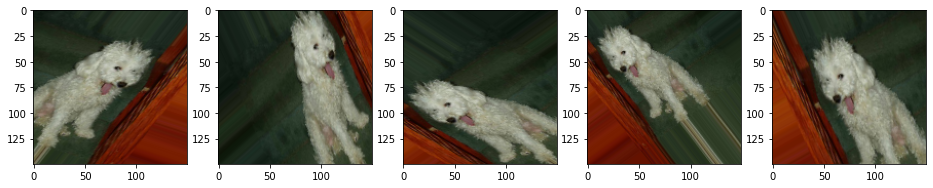

In [15]:
img_id = 2595
cat_generator = train_datagen.flow(train_imgs[img_id:img_id+1], train_labels[img_id:img_id+1],
                                   batch_size=1)
cat = [next(cat_generator) for i in range(0,5)]
fig, ax = plt.subplots(1,5, figsize=(16, 6))
print('Labels:', [item[1][0] for item in cat])
l = [ax[i].imshow(cat[i][0][0]) for i in range(0,5)]

Labels: ['dog', 'dog', 'dog', 'dog', 'dog']


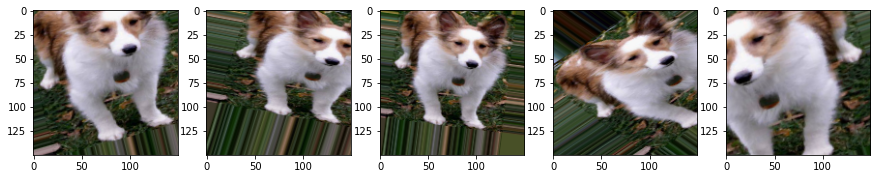

In [16]:
img_id = 1991
dog_generator = train_datagen.flow(train_imgs[img_id:img_id+1], train_labels[img_id:img_id+1],
                                   batch_size=1)
dog = [next(dog_generator) for i in range(0,5)]
fig, ax = plt.subplots(1,5, figsize=(15, 6))
print('Labels:', [item[1][0] for item in dog])
l = [ax[i].imshow(dog[i][0][0]) for i in range(0,5)]

In [18]:
train_generator = train_datagen.flow(train_imgs, train_labels_enc, batch_size=30)
val_generator = val_datagen.flow(validation_imgs, validation_labels_enc, batch_size=20)

input_shape = (150, 150, 3)

In [19]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers

model = Sequential()

model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', 
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))


model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        9280      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
history = model.fit_generator(train_generator, steps_per_epoch=100, epochs=100,
                              validation_data=val_generator, validation_steps=50, verbose=1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
